## Testing 3 different values of sparsity : 0.2 0.5 and 0.8 PHI1 

In [2]:
import numpy as np
data_path = "/Users/waelbenslima/Desktop/data/phione1.txt"
data = np.loadtxt(data_path)
data_reshaped = data.reshape((1331, 171, 171))
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))

## Sparsity 0.2

Training with sparsity = 0.2
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 774ms/step - loss: 0.0807 - val_loss: 0.0140
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 656ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 914ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 864ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 701ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 657ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 963ms/step - loss: 9.4376e-04 - val_loss: 8.6542e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 791ms/step - loss: 7.8801e-04 - val_loss: 0.0018
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 620ms/step - loss: 0.0011 - val_loss: 6.0650e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - loss: 6.1876e-04 - val_loss:

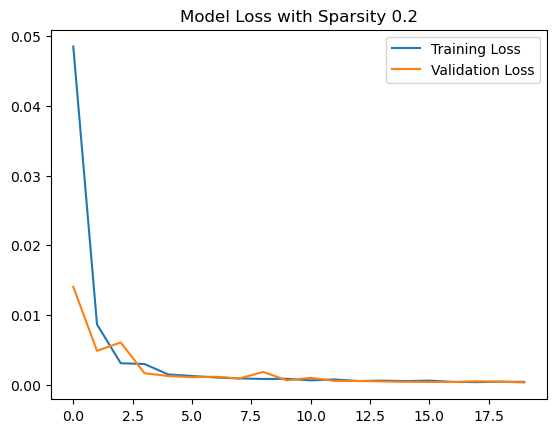

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)
phi1_norm = data_reshaped / np.max(data_reshaped)

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.2
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi1_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


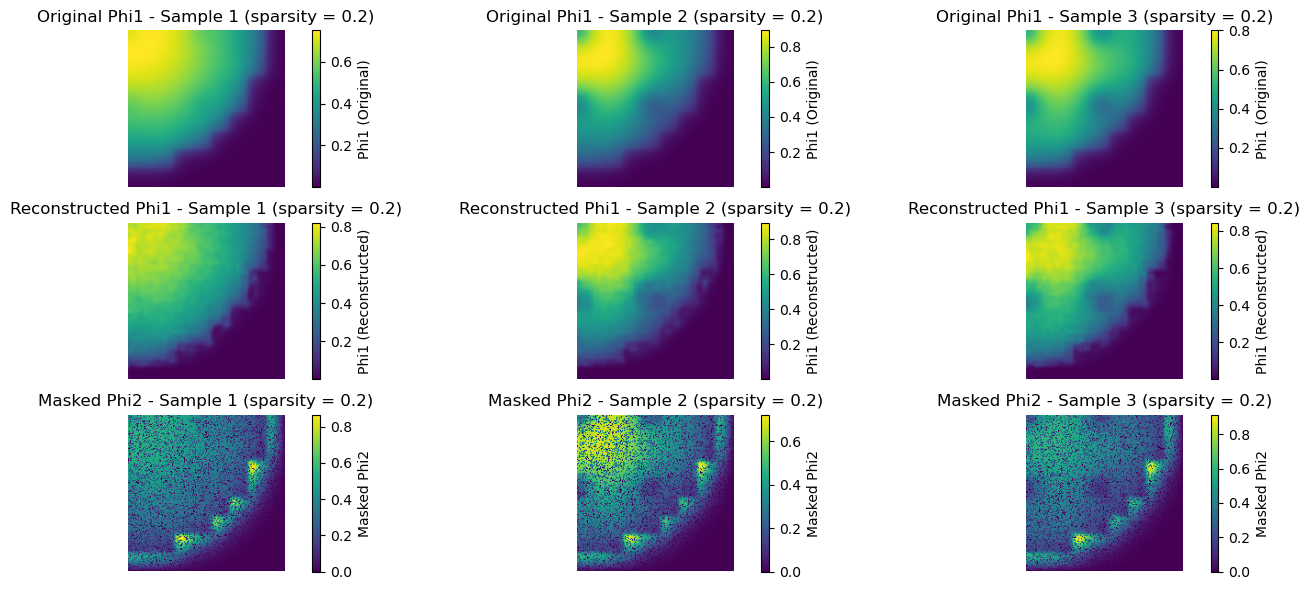

In [12]:
# Predict the output for the noisy input (sparsity = 0.2)
predicted_phi1_002 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Calculate and print the metrics
y_true_flat = y_test.flatten()
y_pred_flat = predicted_phi1_002.flatten()

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi1_002[0].reshape(171, 171), data_range=1)
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

print(f"Sigma = 0.2:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")


Sigma = 0.2:
RMSE: 0.017258046467611417
L∞ Error: 0.29622287173299033
SSIM: 0.9336152473696065
L2 Error: 48.221795291791885
Relative L2 Error: 4.05%


## Sparsity 0.5

Training with sparsity = 0.5
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 763ms/step - loss: 0.0847 - val_loss: 0.0158
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 687ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 651ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 631ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 580ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 564ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 626ms/step - loss: 9.8149e-04 - val_loss: 0.0011
Epoch 12

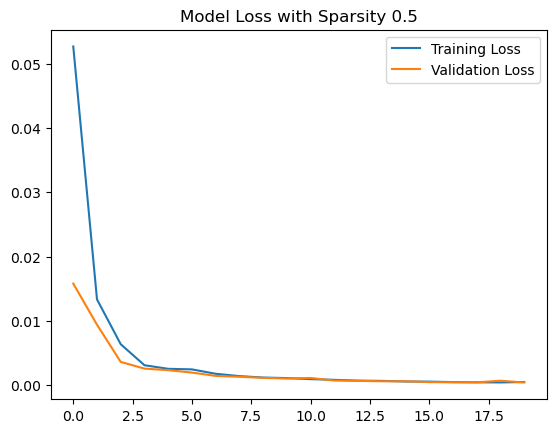

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)
phi1_norm = data_reshaped / np.max(data_reshaped)

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.5
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi1_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


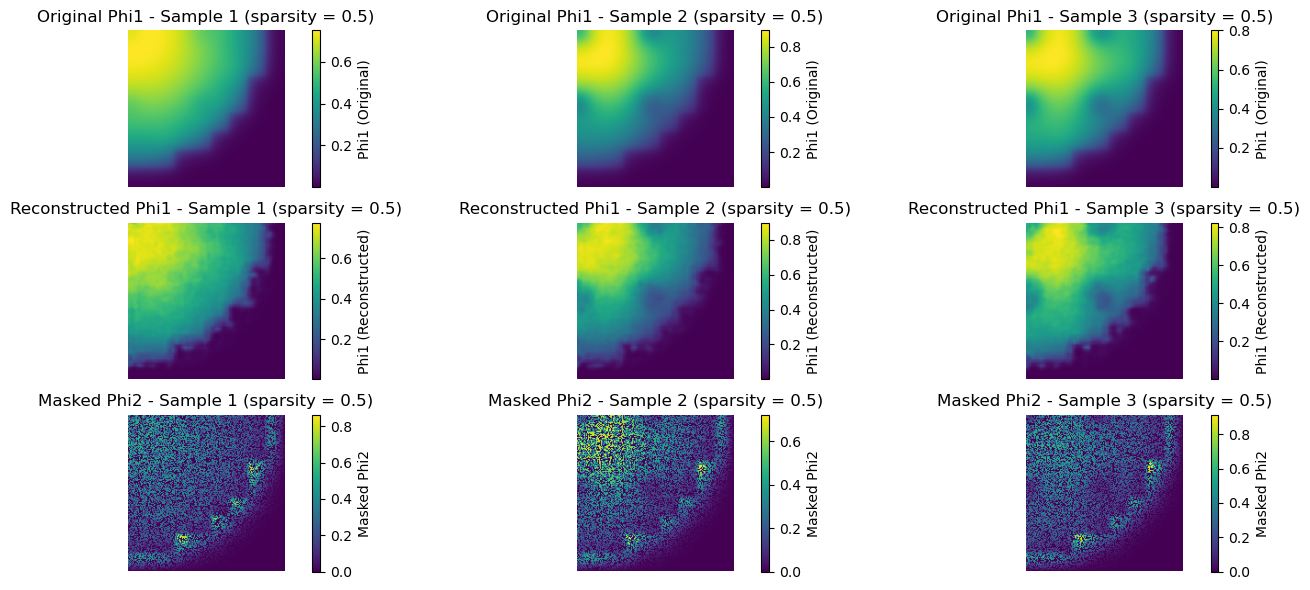

In [18]:
# Predict the output for the noisy input (sparsity = 0.5)
predicted_phi1_005 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
# Calculate and print the metrics
y_true_flat = y_test.flatten()
y_pred_flat = predicted_phi1_005.flatten()

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi1_005[0].reshape(171, 171), data_range=1)
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

print(f"Sigma = 0.5:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")

Sigma = 0.5:
RMSE: 0.020486896060836975
L∞ Error: 0.36200049888296815
SSIM: 0.9114298632003954
L2 Error: 57.2437274325306
Relative L2 Error: 4.81%


## Sparsity 0.8

Training with sparsity = 0.8
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 578ms/step - loss: 0.0844 - val_loss: 0.0184
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 569ms/step - loss: 0.0182 - val_loss: 0.0146
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 584ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 581ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 581ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 576ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/20


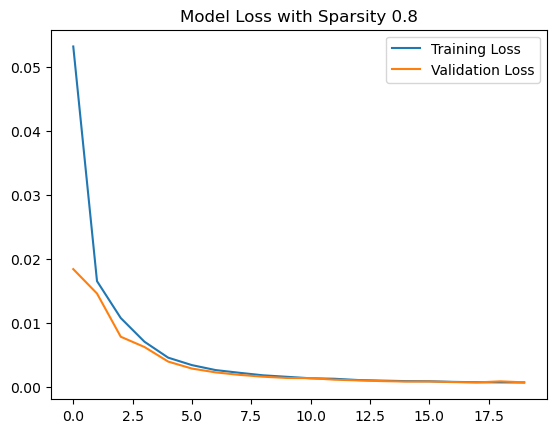

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)
phi1_norm = data_reshaped / np.max(data_reshaped)

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.8
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi1_norm, masks, test_size=0.2, random_state=42
)

# Define the CNN model for reconstruction
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


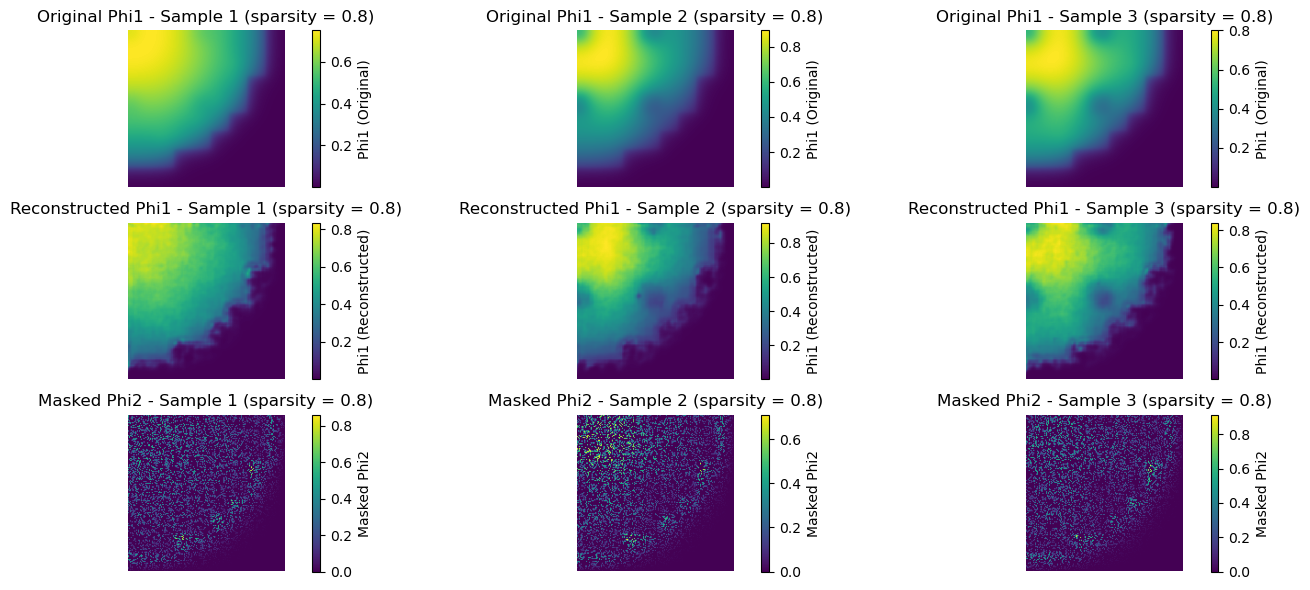

In [24]:
# Predict the output for the noisy input (sparsity = 0.8)
predicted_phi1_08 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi1 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Original)')
    plt.title(f'Original Phi1 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Reconstructed Phi1 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi1_08[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi1 (Reconstructed)')
    plt.title(f'Reconstructed Phi1 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

plt.tight_layout()
plt.show()



In [26]:
# Calculate and print the metrics
y_true_flat = y_test.flatten()
y_pred_flat = predicted_phi1_08.flatten()

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi1_08[0].reshape(171, 171), data_range=1)
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

print(f"Sigma = 0.8:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")

Sigma = 0.8:
RMSE: 0.025934297784949965
L∞ Error: 0.7368828651764281
SSIM: 0.8961055357120932
L2 Error: 72.46465590235267
Relative L2 Error: 6.09%


## Final Plot 